In [2]:
import os
os.chdir('/content')

from google.colab import files

uploaded = files.upload()

!ls

Saving ssh.tar.gz to ssh.tar.gz
sample_data  ssh.tar.gz


In [3]:
#Remove the .ssh Folder if it already exists
!rm -rf /root/.ssh

#Create a new .ssh folder
!mkdir /root/.ssh

#Unzip the archive file
!tar xzvf ssh.tar.gz

#Copy the files to /root/.ssh
!cp ssh-colab/* /root/.ssh && rm -rf ssh-colab && rm -rf ssh.tar.gz
!chmod 700 /root/.ssh

#Add the git server as a ssh known host
!touch /root/.ssh/known_hosts
!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts

ssh-colab/
ssh-colab/id_rsa_colab
ssh-colab/config
ssh-colab/id_rsa_colab.pub
# github.com:22 SSH-2.0-babeld-6c2374e6
# github.com:22 SSH-2.0-babeld-6c2374e6
# github.com:22 SSH-2.0-babeld-6c2374e6


In [4]:
#Run the agent, then run `ssh-add /root/.ssh/id_rsa_colab` in the prompt, optionally followed by `ssh-add -l` to verify, finally type `exit`
!ssh-agent /bin/bash

bash: cannot set terminal process group (123): Inappropriate ioctl for device
bash: no job control in this shell
]0;root@c0ac0ce0078d: /contentroot@c0ac0ce0078d:/content# ssh-add /root/.ssh/id_rsa_colab
Identity added: /root/.ssh/id_rsa_colab (pankajb64@gmail.com)
]0;root@c0ac0ce0078d: /contentroot@c0ac0ce0078d:/content# exit
exit


In [0]:
!git config --global user.email "pankajb64@gmail.com"
!git config --global user.name "pankajb64"

In [6]:
!git clone git@github.com:deepskies/stronglensbnns.git

Cloning into 'stronglensbnns'...
remote: Enumerating objects: 409, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 409 (delta 164), reused 390 (delta 145), pack-reused 0
Receiving objects: 100% (409/409), 7.00 MiB | 4.53 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil -q -m rsync -r gs://strong_lens_challenge/Space_set_1/Data_EuclidBig.0/ stronglensbnns/data/

In [9]:
!cd stronglensbnns/data && mkdir -p Space_set_1/Data_EuclidBig.0/ && mv Public/ Space_set_1/Data_EuclidBig.0/ && ls

bayesiancnn  ensai  Space_set_1


In [10]:
!gsutil cp gs://strong_lens_challenge/Space_set_1/euclidB_image_catalog.csv stronglensbnns/data/Space_set_1/euclidB_image_catalog.csv

Copying gs://strong_lens_challenge/Space_set_1/euclidB_image_catalog.csv...
- [1 files][ 11.1 MiB/ 11.1 MiB]                                                
Operation completed over 1 objects/11.1 MiB.                                     


In [0]:
#@title
from __future__ import print_function

import os
import sys
import time
import argparse
import datetime
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from astropy.io import fits
#from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [0]:
os.chdir('stronglensbnns/src/notebooks')

In [13]:
!git pull

Already up to date.


In [0]:
#add the  bayesiancnnn and ensai src to import path - https://stackoverflow.com/a/35273613/7154530
bcnn_module_path = os.path.abspath(os.path.join('../bayesiancnn'))
if bcnn_module_path not in sys.path:
    sys.path.append(bcnn_module_path)
    
ensai_module_path = os.path.abspath(os.path.join('../ensai'))
if ensai_module_path not in sys.path:
    sys.path.append(ensai_module_path)

In [0]:
from BBBlayers import GaussianVariationalInference, FlattenLayer
from BayesianModels.BayesianAlexNet import BBBAlexNet
from BayesianModels.BayesianAlexNetBatchNorm import BBBAlexNetBatchNorm


In [0]:
df = pd.read_csv('../../data/Space_set_1/euclidB_image_catalog.csv', skiprows=24)

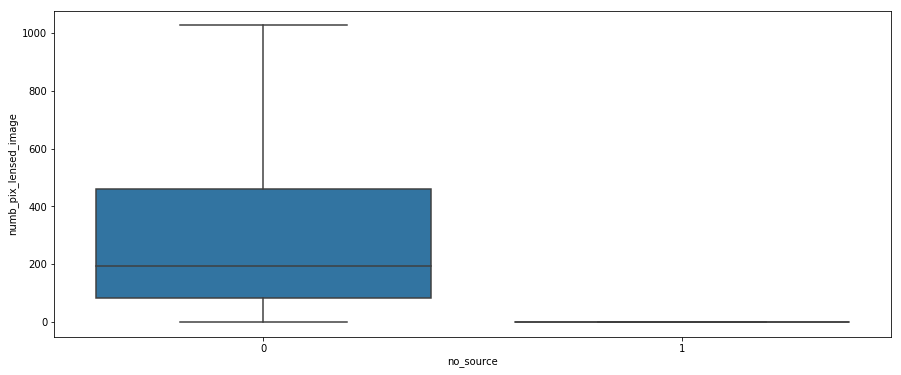

In [17]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=df['no_source'], y=df['numb_pix_lensed_image'], showfliers=False, ax=ax)

In [0]:
df_lens = df.loc[(df['numb_pix_lensed_image'] > 100) & (df['numb_pix_lensed_image'] < 500)]

(0, 2e-10)

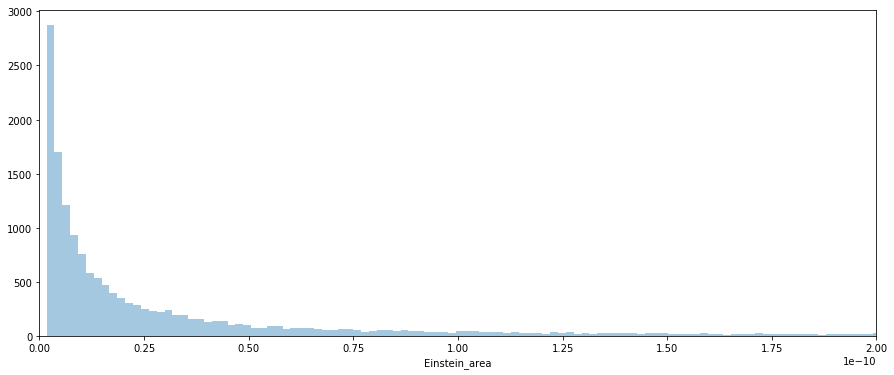

In [0]:
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(df_lens['Einstein_area'], bins=1000, ax=ax, kde=False)
ax.set_xlim(0, 0.2e-9)

It may help to scale the values to avoid running into floating point errors, and also to take the log of the distribution since the above curve is exponential. I found that scaling values by 2e10 and taking log gave a nice symmetric range for distribution

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


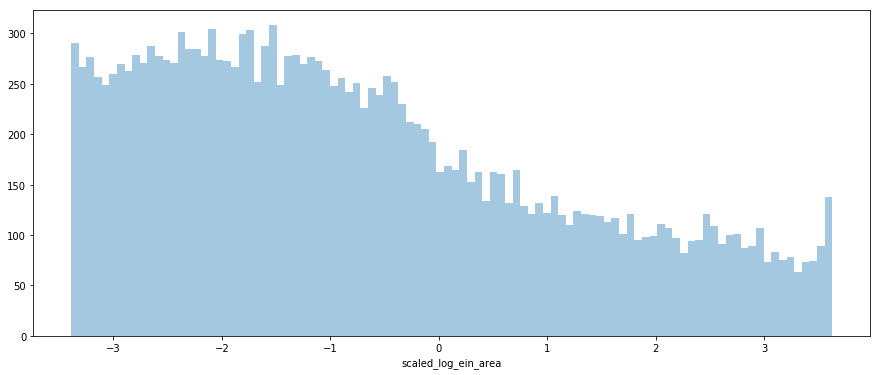

In [19]:
df_lens['scaled_log_ein_area'] = np.log(df_lens['Einstein_area']) + np.log(2e10)
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(df_lens['scaled_log_ein_area'], bins=100, ax=ax, kde=False)
#ax.set_xlim(0, 0.2)

If the instance is a source (i.e `no_source = 0`), then we can a distribution of lensed image pixels with first and third quartile being around 100 and 500. So lets use these instances for training.

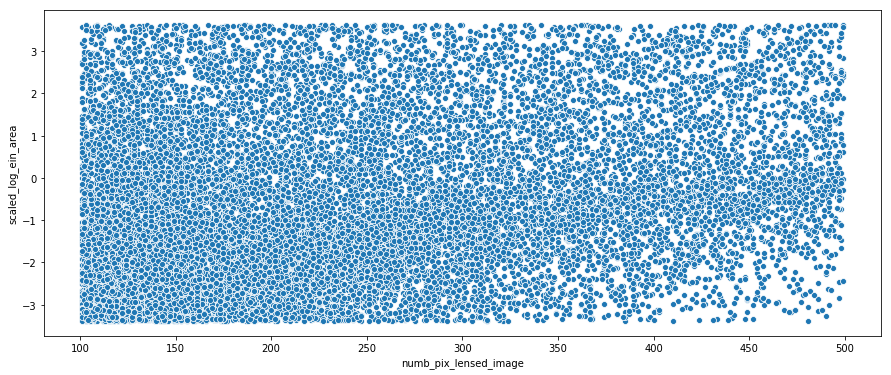

In [0]:
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(df_lens['numb_pix_lensed_image'], df_lens['scaled_log_ein_area'], ax=ax)

So the Einstein area and the number of lensed are uncorrelated, and were likely chosen independently in the simulation.

Load the corresponding input images and labels.

In [0]:
ids = df_lens['ID'].values

In [0]:
files = ['../../data/Space_set_1/Data_EuclidBig.0/Public/Band1/{}'.format(f) for f in os.listdir('../../data/Space_set_1/Data_EuclidBig.0/Public/Band1/')]

In [0]:
df_files = pd.DataFrame()
df_files['fname'] = files
df_files['ID'] = [int(fname.split('-')[1].split('.')[0]) for fname in files]

In [0]:
df_merge = pd.merge(df_lens, df_files, on='ID')

In [0]:
lens_fnames = df_merge['fname'].values
lens_files = [fits.open(fname) for fname in lens_fnames]
lens_images = [f[0].data for f in lens_files]
lens_labels = df_merge['scaled_log_ein_area'].values

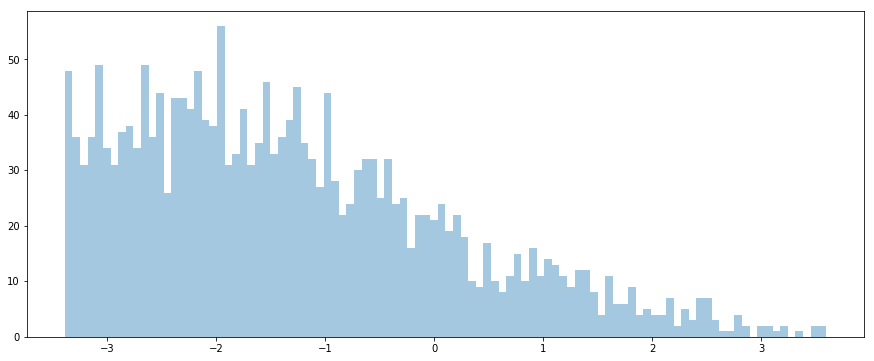

In [25]:
#labels = np.array(areas)
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(lens_labels, kde=False, bins=100, ax=ax)
#ax.set_xlim(0, 0.2)

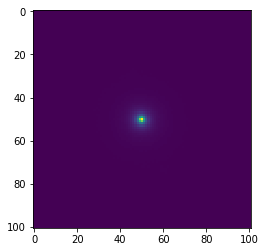

In [26]:
plt.imshow(lens_images[0])

(-5e-11, 5e-11)

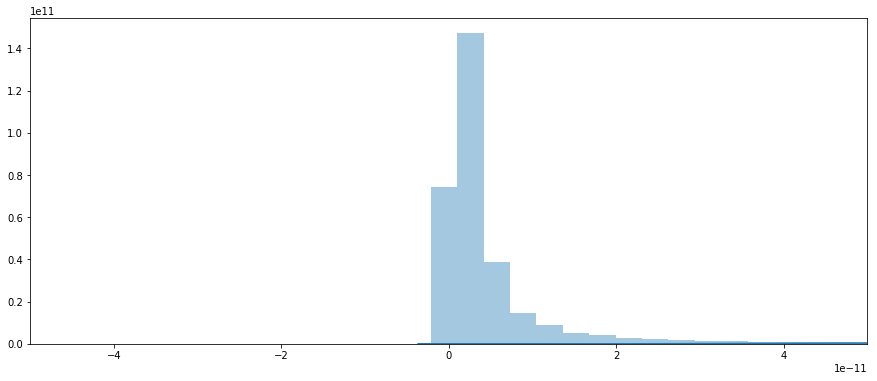

In [0]:
fig, ax = plt.subplots(figsize=(15,6))
sns.distplot(lens_images[0].flatten(), bins=1000, ax = ax)
ax.set_xlim(-0.5e-10, 0.5e-10)

The images also have extremely small magnitudes of the order of 1e-10, so scaling is helpful. I'm currently scale each image individually by its max value

In [0]:
images = np.array(lens_images)/np.max(lens_images, axis=(1,2), keepdims=True)
labels = np.array(lens_labels)
#factor = 1e9
#images = (images - np.mean(images))/np.std(images)
#labels = np.array(areas) - np.mean(areas))/np.std(areas)
#labels = (np.log(np.array(areas)) + np.log(2e10)
#labels = (np.array(areas) - np.mean(areas)) / np.std(areas)  
#images = images[:100]#[labels <= 1, :, :]
#labels = labels[:100]#[labels <= 1]

In [0]:
#@title
#net_type = 'houses-bnn'
#dataset = 'houses'
net_type = 'alexnet'
dataset = 'stronglens-challenge'
numpix_side = 101
outputs = 1
inputs = 1
regression = True
resume = False
start_epoch = 0
n_epochs = 100 #set to 10 for MNIST, 30 for cifar10, and 200 for house pricing
lr = 1e-2
weight_decay = 1e-4
num_samples = 10
beta_type = "Blundell"
resize=32
optim_type = 'Adam'
best_acc = 0
best_loss = np.inf
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 256
# percentage of training set to use as validation
valid_size = 0.1
#load every nth saved epoch (change to a smaller number for classification problems where num_epochs is less)
load_multiple = 1 #set to 25 (or 10) for house pricing, 1 for MNIST, 3 for cifar10
classes = ['einsten_area']
output_names = ['Einstein Area'] #['Einstein Radius', 'Ellipticity (x)', 'Ellipticity (y)', 'Center (x)', 'Center (y)']

In [0]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
if use_cuda is True:
    torch.cuda.set_device(0)

In [0]:
trainX, testX, trainY, testY = train_test_split(images, labels, test_size=0.1, random_state=42) # images, images, labels, labels

In [0]:
def apply_transform(tensor, transform=None):
    return tensor
    '''
    #print(tensor.shape)
    img = TF.to_pil_image(tensor)
    img = transform(img)
    return TF.to_tensor(img)'''

In [0]:
transform_train = transforms.Compose([
    transforms.Resize((resize, resize))
])  

transform_test = transforms.Compose([
    transforms.Resize((resize, resize))
])

In [0]:
trainX = np.array(trainX)#.reshape(-1, numpix_side, numpix_side)
trainY = np.array(trainY).reshape(-1, outputs)

testX = np.array(testX)#.reshape(-1, numpix_side, numpix_side)
testY = np.array(testY).reshape(-1, outputs)

tensor_x_train = torch.stack([apply_transform(torch.Tensor(trainX[i, :, :]), transform_train) for i in range(trainX.shape[0])]) # transform to torch tensors
tensor_y_train = torch.stack([torch.Tensor(i) for i in trainY])
trainset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train) # create your datset

tensor_x_test = torch.stack([apply_transform(torch.Tensor(testX[i, :, :]), transform_test) for i in range(testX.shape[0])]) # transform to torch tensors
tensor_y_test = torch.stack([torch.Tensor(i) for i in testY])
testset = torch.utils.data.TensorDataset(tensor_x_test,tensor_y_test) # create your datset

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [0]:
def learning_rate(init, epoch):
    optim_factor = 0
    if(epoch > 160):
        optim_factor = 3
    elif(epoch > 120):
        optim_factor = 2
    elif(epoch > 60):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

In [0]:
dataloader = iter(testloader)

In [0]:
features, targets = dataloader.next()

In [0]:
targets[2].numpy()

array([-2.1839864], dtype=float32)

In [37]:
lr=1e-3
weight_decay=1e-4
from torchsummary import summary

'''net = nn.Sequential(nn.Conv2d(inputs, 64, kernel_size=11, stride=4, padding=5),
                    nn.Softplus(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.BatchNorm2d(64),
                    nn.Conv2d(64, 192, kernel_size=5,  padding=2),
                    nn.Softplus(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.BatchNorm2d(192),
                    nn.Conv2d(192, 384, kernel_size=3,  padding=1),
                    nn.Softplus(),
                    nn.BatchNorm2d(384),
                    nn.Conv2d(384, 256, kernel_size=3,  padding=1),
                    nn.Softplus(),
                    nn.BatchNorm2d(256),
                    nn.Conv2d(256, 128, kernel_size=3,  padding=1),
                    nn.Softplus(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.BatchNorm2d(128),
                    FlattenLayer(128),
                    nn.Linear(128, outputs),
                    nn.BatchNorm1d(outputs)
                   )'''

net = nn.Sequential(nn.Conv2d(inputs, 192, kernel_size=11, stride=4, padding=5),
                    nn.Softplus(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    #nn.Dropout(0.25),
                    nn.BatchNorm2d(192),
                    nn.Conv2d(192, 384, kernel_size=3,  padding=1),
                    nn.Softplus(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    #nn.Dropout(0.25),
                    nn.BatchNorm2d(384),
                    nn.Conv2d(384, 256, kernel_size=3,  padding=1),
                    nn.Softplus(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    #nn.Dropout(0.25),
                    nn.BatchNorm2d(256),
                    nn.Conv2d(256, 128, kernel_size=3,  padding=1),
                    nn.Softplus(),
                    nn.MaxPool2d(kernel_size=2, stride=2),
                    #nn.Dropout(0.25),
                    nn.BatchNorm2d(128),
                    FlattenLayer(128),
                    #nn.Dropout(0.1),
                    nn.Linear(128, outputs)
                   )

if use_cuda:
    net.cuda()

summary(net, input_size=(inputs, numpix_side, numpix_side))


criterion = torch.nn.MSELoss()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 26, 26]          23,424
          Softplus-2          [-1, 192, 26, 26]               0
         MaxPool2d-3          [-1, 192, 13, 13]               0
       BatchNorm2d-4          [-1, 192, 13, 13]             384
            Conv2d-5          [-1, 384, 13, 13]         663,936
          Softplus-6          [-1, 384, 13, 13]               0
         MaxPool2d-7            [-1, 384, 6, 6]               0
       BatchNorm2d-8            [-1, 384, 6, 6]             768
            Conv2d-9            [-1, 256, 6, 6]         884,992
         Softplus-10            [-1, 256, 6, 6]               0
        MaxPool2d-11            [-1, 256, 3, 3]               0
      BatchNorm2d-12            [-1, 256, 3, 3]             512
           Conv2d-13            [-1, 128, 3, 3]         295,040
         Softplus-14            [-1, 12

In [0]:
#@title
def trainf(epoch):
    net.train()
    train_loss = 0
    m = math.ceil(len(trainset) / batch_size)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate(lr, epoch), weight_decay=weight_decay)

    print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, lr))
    for batch_idx, (inputs_value, targets) in enumerate(trainloader):
        x = inputs_value.view(-1, inputs, numpix_side, numpix_side).repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(1, 1)
        #print(y[:10])
        if use_cuda:
            x, y = x.cuda(), y.cuda() # GPU settings

        
        # Forward Propagation
        x, y = Variable(x), Variable(y)
        outs = net(x)
        #print(outs[:10])
        #print(outs[0], y[0])
        #print(y)
        #print(x.shape)
        #print(outs.shape)
        #print(y.shape)
        loss = criterion(outs, y)  # Loss
        optimizer.zero_grad()
        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update

        train_loss += loss.data.item()
        loss = loss.data.item()
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tIter Loss: %.4f, Cumulative Loss: %.4f' %(epoch, n_epochs-1, batch_idx+1,
                    (len(trainset)//batch_size)+1, loss, train_loss))

        sys.stdout.flush()
        
    return train_loss

In [0]:
#@title 
def testf(epoch, save_epoch=False):
    global best_acc, best_loss
    net.eval()
    test_loss = 0
    
    m = math.ceil(len(testset) / batch_size)
    for batch_idx, (inputs_value, targets) in enumerate(testloader):
        x = inputs_value.view(-1, inputs, numpix_side, numpix_side).repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(1, 1)
    
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs = net(x)
        
        loss = criterion(outs, y)

        test_loss += loss.data.item()
        loss = loss.data.item()
    
    
    print('\n| Validation Epoch #%d\t\t\tLoss: %.4f' %(epoch, test_loss))

    state = {
        'net':net,
        'epoch':epoch,
        'loss': test_loss,
        }
    
    if save_epoch:
       if not os.path.isdir('checkpointf'):
            os.mkdir('checkpointf')
       
       save_point = './checkpointf/checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
       torch.save(state, save_point)
       print('Saved Epoch {} as {}'.format(epoch, save_point))
      
    if test_loss < best_loss:
        print('| Saving Best model...\t\t\tLoss = %.2f' %(test_loss))
        best_loss = test_loss
        
        if not os.path.isdir('checkpointf'):
            os.mkdir('checkpointf')
        save_point = './checkpointf/'+dataset+os.sep
        ckpt_name = f'model_{net_type}_{dataset}_nn.pt'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+ckpt_name)
    
    return test_loss

In [40]:
#@title
elapsed_time = 0
saved_epochs = []

train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(0, 50):#start_epoch+n_epochs):
    start_time = time.time()

    tloss = trainf(epoch)
    train_losses.append(tloss)
    if (epoch%1 == 0):
        vloss = testf(epoch, save_epoch = True )
        saved_epochs.append(epoch)
        val_losses.append(vloss)
    else:
        vloss = testf(epoch)
        val_losses.append(vloss)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' %(get_hms(elapsed_time)))

if not regression:    
  print('\n Test results : Acc@1 = %.2f%%' %(best_acc))
else:
  print('\n Test results : Loss = %.2f' %(best_loss))


=> Training Epoch #0, LR=0.0010
| Epoch [  0/ 99] Iter[  8/  8]		Iter Loss: 3.2104, Cumulative Loss: 32.4473
| Validation Epoch #0			Loss: 3.9186
Saved Epoch 0 as ./checkpointf/checkpoint-alexnet-stronglens-challenge-epoch-0.pt
| Saving Best model...			Loss = 3.92
| Elapsed time : 0:00:01

=> Training Epoch #1, LR=0.0010
| Epoch [  1/ 99] Iter[  8/  8]		Iter Loss: 2.7902, Cumulative Loss: 28.1835
| Validation Epoch #1			Loss: 4.4585
Saved Epoch 1 as ./checkpointf/checkpoint-alexnet-stronglens-challenge-epoch-1.pt
| Elapsed time : 0:00:02

=> Training Epoch #2, LR=0.0010
| Epoch [  2/ 99] Iter[  8/  8]		Iter Loss: 3.2253, Cumulative Loss: 26.5566
| Validation Epoch #2			Loss: 4.3187
Saved Epoch 2 as ./checkpointf/checkpoint-alexnet-stronglens-challenge-epoch-2.pt
| Elapsed time : 0:00:04

=> Training Epoch #3, LR=0.0010
| Epoch [  3/ 99] Iter[  8/  8]		Iter Loss: 2.7534, Cumulative Loss: 22.9415
| Validation Epoch #3			Loss: 9.0750
Saved Epoch 3 as ./checkpointf/checkpoint-alexnet-stro

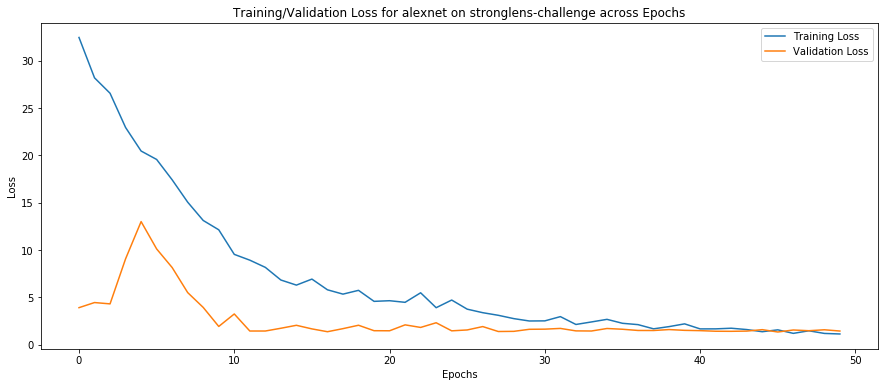

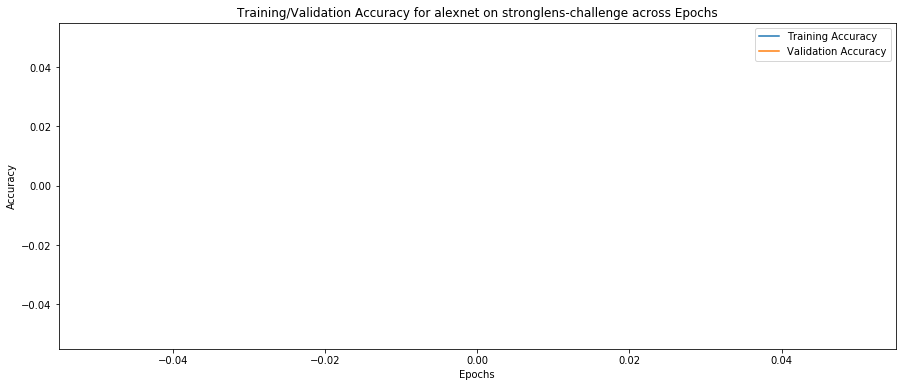

In [41]:
#@title
def plot_loss():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
  plt.plot(np.arange(len(val_losses)), val_losses, label='Validation Loss')
  plt.title('Training/Validation Loss for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  #plt.ylim(0, 250)
  plt.legend()
  
def plot_acc():
  fig = plt.figure(figsize=(15,6))
  plt.plot(np.arange(len(train_accs)), train_accs, label='Training Accuracy')
  plt.plot(np.arange(len(val_accs)), val_accs, label='Validation Accuracy')
  plt.title('Training/Validation Accuracy for {} on {} across Epochs'.format(net_type, dataset))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  
plot_loss()
plot_acc()

In [0]:
def load_states():
  states = []
  for epoch in saved_epochs:
    filename = './checkpointf/checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
    state = torch.load(filename)
    states.append(state)
  return states

states = load_states()

In [0]:
#idx_interest = [0, 10, 20, 50, 100, 200, 500, 999]
nets = [state['net'] for idx, state in enumerate(states) ]#if idx in idx_interest] #%1 == 0]# 
epochs = [state['epoch'] for idx, state in enumerate(states) ]#if idx in idx_interest] #%1 == 0]#

In [0]:
def get_predictions_f(dataloader):
    predsY = []
    labs = []
    for batch_idx, (inputs_value, targets) in enumerate(dataloader):
        x = inputs_value.view(-1, inputs, numpix_side, numpix_side).repeat(1, 1, 1, 1)
        #x_nobias = remove_image_intensity_bias(x)
        #x = x_nobias.repeat(num_samples, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(1, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs = net(x)
        preds = outs.detach().cpu().numpy()
        #print(preds.shape)
        mean_preds = preds#.reshape(1, -1, outputs).mean(axis=0)
        #print(mean_preds)
        predsY.extend(mean_preds.squeeze())
        labs.extend(y.detach().cpu().numpy().squeeze())
    return np.array(predsY), np.array(labs)

In [0]:
def scatter_plots_f():
    preds, labs = get_predictions_f(testloader)
    print(preds.shape)
    print(labs.shape)
    #print(preds)
    #print(labs)
    pt = torch.from_numpy(preds)
    pl = torch.from_numpy(labs)
    loss = criterion(pt, pl)
    print('Loss: {}'.format(loss))
    #print(testY)
    fig, ax = plt.subplots(figsize=(15,6))
    points = [[-4, 4]]
    trainY_mean = np.mean(trainY, axis=0)
    lr = LinearRegression()
    lr.fit(labs.reshape(-1, 1), preds)
    pp = lr.predict(labs.reshape(-1, 1))    
    for j in range(outputs):
        sns.scatterplot(x=labs, y=preds, ax=ax)
        ax.plot(points[j], points[j], '--r', label='ideal relationship line')
        ax.plot(points[j], [trainY_mean[j], trainY_mean[j]], '--g', label='line if predicting train mean')
        ax.plot(labs, pp*1, '--b', label='current relationship line')
        
        ax.set_xlabel('{}: true'.format(output_names[j]))
        ax.set_ylabel('{}: predicted'.format(output_names[j]))
        ax.set_xlim(points[j])
        ax.set_ylim(points[j])
        ax.legend()
    fig.suptitle('Scatter plots for true vs predicted values for the parameters')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    

(209,)
(209,)
Loss: 1.3491424322128296


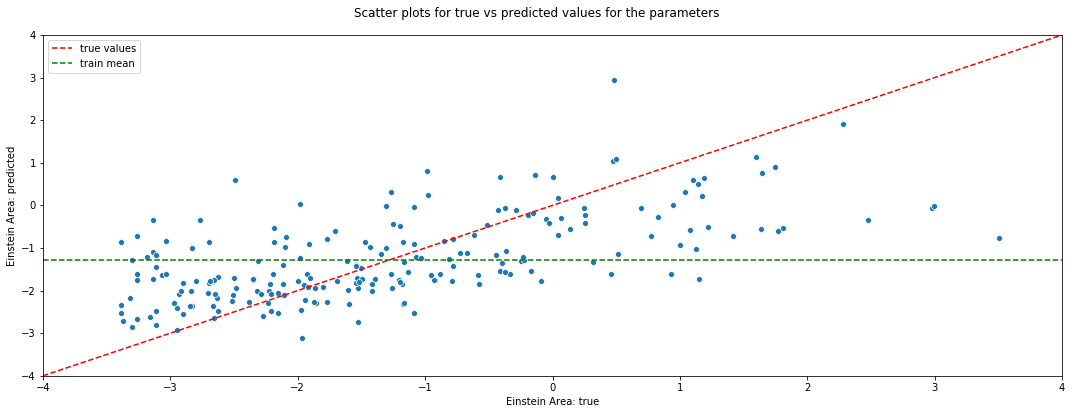

In [51]:
scatter_plots_f()

(209,)
(209,)
Loss: 1.4517405033111572


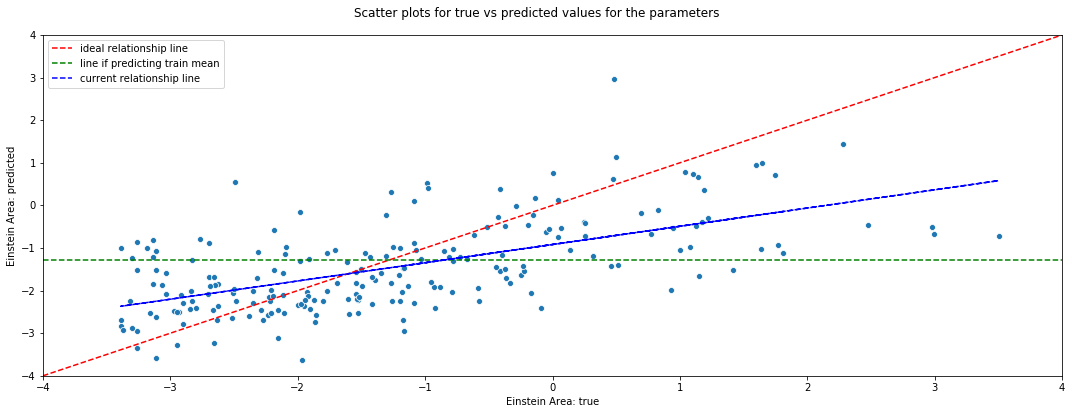

In [86]:
scatter_plots_f()

In [0]:
criterion

MSELoss()

[-0.69834316 -1.8933476  -0.94693375 -1.7379405  -0.07729656 -1.9728365
 -1.2459908  -1.1671361   0.70576847 -1.4075742  -2.4429557  -1.5956941
 -1.9052382  -0.28561723 -1.8477255  -1.1202658  -1.6421733  -0.39339864
 -2.4409037  -1.7535002  -2.557704   -1.7942603  -0.552374   -0.8782064
 -1.9532638  -0.99285805 -0.84225404  0.23685995 -1.5258068  -2.608799
  1.537473   -0.26257232 -0.9478946  -2.5574012  -2.51446    -1.5449021
 -3.350667   -1.6845536  -1.9235597  -0.9177486  -0.27166912 -1.8386912
 -1.7665517  -1.2608421  -1.8941028  -1.5353222  -2.0718277  -0.29246596
 -0.6928308  -1.1998433  -1.7939005  -0.46831995 -2.452119   -0.78630424
 -1.3891354  -0.83403504 -1.2209462   0.05710945 -2.493929   -1.0900899
 -0.83502007 -0.12520847 -2.008237   -2.17899    -1.7016206   0.5170722
 -1.8472254  -1.1062677  -0.30393404 -2.4584384  -0.3026483  -1.3984331
 -2.201796   -0.06304264 -0.6921377  -0.89284015 -0.41007552 -1.8729836
 -0.48491776 -1.5102102  -2.6732407  -2.8787642  -1.8445876  -

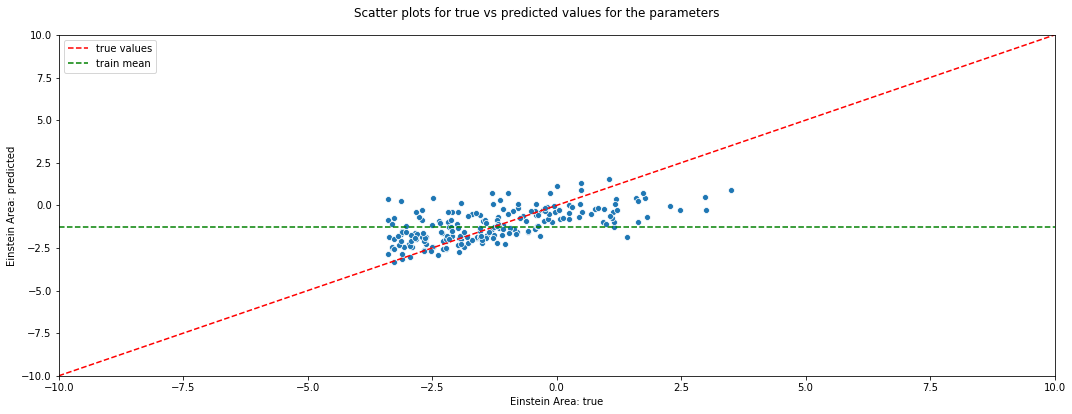

In [0]:
scatter_plots_f()

In [0]:
np.mean(testY)

-0.8406609494900326

In [0]:
from google.colab import files
files.download( "./checkpoint-alexnet-stronglens-challenge-epoch-999.pt" )


In [0]:
targets[6]

tensor([1.1449])

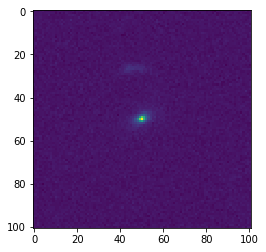

In [0]:
plt.imshow(features[6].squeeze())
#features[6].shape

In [0]:
testY[6]

array([1.14492319])

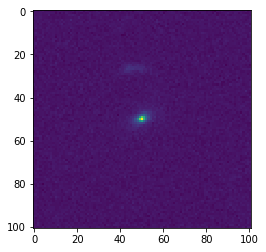

In [0]:
plt.imshow(testX[6].squeeze())

In [0]:
targets[2]

tensor([-2.1840])

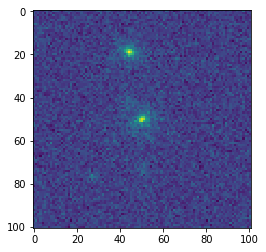

In [0]:
plt.imshow(features[2].squeeze())


In [0]:
testY[2]

array([-2.18398639])

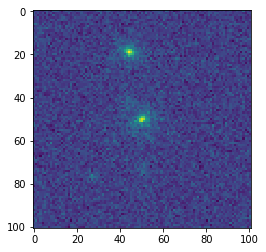

In [0]:
plt.imshow(testX[2].squeeze())


In [0]:
testX[2]

array([[-0.03118862,  0.03263293,  0.01897468, ..., -0.05712032,
         0.01954625, -0.06988112],
       [ 0.10623123, -0.04070745,  0.06104016, ..., -0.12101904,
         0.03019935,  0.05595255],
       [ 0.06638339,  0.02913772, -0.0936354 , ..., -0.02538867,
        -0.10750613, -0.01265403],
       ...,
       [ 0.06867588,  0.03683395, -0.00133451, ..., -0.03795612,
         0.03834842, -0.03783647],
       [ 0.01976168,  0.05866597,  0.02887161, ...,  0.05466923,
        -0.0381833 , -0.06175483],
       [ 0.07699335,  0.05387036,  0.00519225, ...,  0.04815482,
        -0.12860762,  0.14607134]], dtype=float32)

In [0]:
features[2]

tensor([[-0.0312,  0.0326,  0.0190,  ..., -0.0571,  0.0195, -0.0699],
        [ 0.1062, -0.0407,  0.0610,  ..., -0.1210,  0.0302,  0.0560],
        [ 0.0664,  0.0291, -0.0936,  ..., -0.0254, -0.1075, -0.0127],
        ...,
        [ 0.0687,  0.0368, -0.0013,  ..., -0.0380,  0.0383, -0.0378],
        [ 0.0198,  0.0587,  0.0289,  ...,  0.0547, -0.0382, -0.0618],
        [ 0.0770,  0.0539,  0.0052,  ...,  0.0482, -0.1286,  0.1461]])

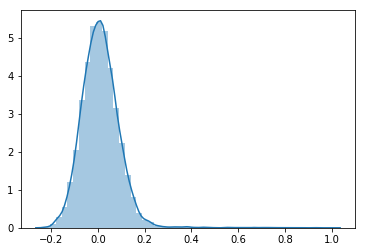

In [0]:
sns.distplot(features[2].cpu().numpy().ravel())

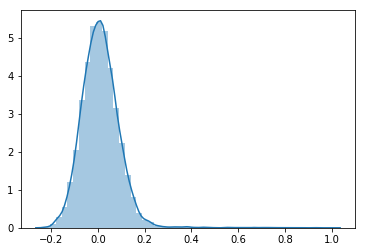

In [0]:
sns.distplot(testX[2].ravel())

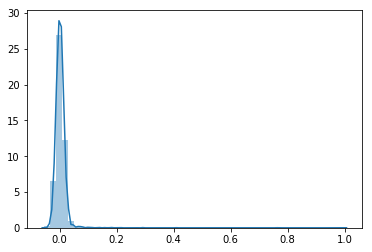

In [0]:
sns.distplot(features[6].cpu().numpy().ravel())

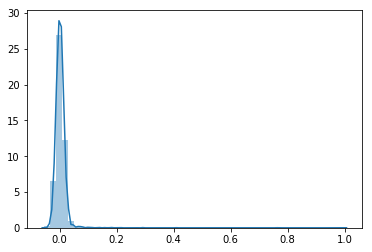

In [0]:
sns.distplot(testX[6].ravel())

In [0]:
testX[2].shape

(101, 101)

In [0]:
features[2].shape

torch.Size([101, 101])